In [1]:
# Exercise_1
# main simple classification Iris data
# TODO**
# Names of group members: Fabian Bloch and Christopher Mahn
# Date: April 24th, 2023
# TODO**

In [2]:
#%% Load modules
import numpy as np
import pandas as pd
# import csv

# torch modules
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# plot module
import matplotlib.pyplot as plt

# evaluate modele
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# module for interoperable file-operations
import os
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(f'Path of this exercise: {path}')

Path of this exercise: /hdd/repository/hcu-ma-gmt-big-data-analysis/data/ex2


In [3]:
# %% CUDA for PyTorch
# Right at the beginning: check if a cuda compatible GPU is available in your computer. 
# If so, set device = cuda:0 which means that later all calculations will be performed on the graphics card. 
# If no GPU is available, the calculations will run on the CPU, which is also absolutely sufficient for these exercises.
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

Device: cuda:0 -- Number of devices: 1


In [4]:
# Mounting Google Drive locally 
# from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
# drive.mount('/content/drive')
# you can also choose one of the other options to load data
# therefore see https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

In [5]:
# %% read data
# path to wine quality data
data_path = os.path.join(path, 'data/iris_flowers/iris.data')

# read csv sheet with pandas
df = pd.read_csv(data_path, sep=',')

# # drop nan data
df = df.dropna()
# drop each row where there is not at least 21 not nan data
# df = df.dropna(thresh=21) # there are many nan in row 4 12 14, which can cause errors

# get numpy out of pandas dataframe
data = df.values
# data=df.to_numpy()

# get column names to see, which columns we have to extract as x and y
column_names = np.array(df.columns[:], dtype=np.str_)

# TODO**
print(f'Größe des Datensatzes: {np.shape(data)[0]}')
print(f'Dimension des Datensatzes: {np.shape(data)[1]}')
# TODO**

Größe des Datensatzes: 149
Dimension des Datensatzes: 5


In [6]:
# %% split in X and Y
# extract any feature you want as X 
# extract target values as Y
x = np.array(data[:,:-1], dtype=np.float32)
# x = np.array(data[:,6], dtype=np.float32)
y = pd.factorize(data[:,-1])[0]

class_names = np.unique(data[:,-1])

# save number of classes
nc = np.max(y)+1

print('x shape:', x.shape)
print('y shape:', y.shape)
print('number of classes', nc)

x shape: (149, 4)
y shape: (149,)
number of classes 3


In [7]:
# %% normalize X between (0,1). If multiple features in X are selected, each feature is normalized individually
scale_x = np.max(x, axis=0)
x = x/scale_x
print('Scale_x:',scale_x)

Scale_x: [7.9 4.4 6.9 2.5]


In [8]:
# %% convert to torch tensors
# if tensors have only one dimension, an artificial dimension is created with unsqueeze (e.g. [10]->[10,1], so 1D->2D)
Y = torch.from_numpy(y)
Y = Y.long()

# produce onehot target tensor
# scatter_ mehtod fills the tensor with values from a source tensor along the indices provided as arguments
# oh = one hot encoding
Y_oh = torch.zeros(Y.shape[0], nc)
Y_oh.scatter_(1,Y.unsqueeze(1), 1.0)

X = torch.from_numpy(x)
X = X.float()
if len(X.shape)==1:
    X = X.unsqueeze(dim=1)

In [9]:
# %% Split dataset in training, validation and test tensors
# TODO**
prop_train = 0.5
prop_val = 0.25
prop_test = 0.25
# TODO**

sample_num = {'all': X.shape[0], 
              'train': round(prop_train*X.shape[0]),
              'val': round(prop_val*X.shape[0]),
              'test': round(prop_test*X.shape[0])}

# idx shuffle
idx = np.random.choice(sample_num['all'], sample_num['all'], replace=False)
# assign idx to each sample
sample_idx = {'all': idx[:], 
              'train': idx[0:sample_num['train']],
              'val': idx[sample_num['train']:sample_num['train']+sample_num['val']],
              'test': idx[sample_num['train']+sample_num['val']:]}

# Create train data
X_train = X[sample_idx['train']]
Y_train_oh = Y_oh[sample_idx['train']]
Y_train = Y[sample_idx['train']]

# Create validation data
X_val = X[sample_idx['val']]
Y_val_oh = Y_oh[sample_idx['val']]
Y_val = Y[sample_idx['val']]

# Create test data
X_test = X[sample_idx['test']]
Y_test_oh = Y_oh[sample_idx['test']]
Y_test = Y[sample_idx['test']]

# Show data point
print('Input of first ten train Sample:', X_train[0:10])
print('Target of first ten train Sample:', Y_train[0:10])
print('One-Hot-Encoded Target of first ten train Sample:', Y_train_oh[0:10])

Input of first ten train Sample: tensor([[0.8481, 0.5682, 0.8406, 0.7200],
        [0.7975, 0.6591, 0.8116, 0.7200],
        [0.8861, 0.7273, 0.6812, 0.5600],
        [0.5823, 0.7273, 0.2029, 0.0800],
        [0.6582, 0.7955, 0.2174, 0.0800],
        [0.7975, 0.6364, 0.7391, 0.6000],
        [0.6962, 0.9545, 0.2029, 0.0800],
        [0.7342, 0.6136, 0.5942, 0.4000],
        [0.7215, 0.6591, 0.6087, 0.5200],
        [0.8354, 0.6591, 0.6667, 0.5200]])
Target of first ten train Sample: tensor([2, 2, 1, 0, 0, 2, 0, 1, 1, 1])
One-Hot-Encoded Target of first ten train Sample: tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])


In [10]:
#%% class of neural network 'ClassificationNet'
# set up layer and architecture of network in constructor __init__
# define operations on layer in forward pass method
class ClassificationNet(nn.Module):
    
    def __init__(self, inputSize, outputSize):
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(inputSize, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, outputSize)
    
    def forward(self, x):
        # max pooling over (2, 2) window
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [11]:
#%% Specify network parameter
# TODO**  
inputDim = 4
outputDim = 3
 
# Create instance of ClassificationNet
net = ClassificationNet(inputDim, outputDim)
# TODO** 

In [12]:
#%% Send tensors and networks to GPU (if you have one which supports cuda) for faster computations
# Note: Y is one-hot-encoded
X_train, Y_train_oh = X_train.to(device), Y_train_oh.to(device)
X_val, Y_val_oh = X_val.to(device), Y_val_oh.to(device)
X_test, Y_test_oh = X_test.to(device), Y_test_oh.to(device)

# The network itself must also be sent to the GPU. Either you write net = RegressNet() and then later net.to(device) or directly net = RegressNet().to(device)
# The latter option may have the advantage that the instance net is created directly on the GPU, whereas in variant 1 it must first be sent to the GPU.
if device_num>1:
    print("Let's use", device_num, "GPU's")
    net = nn.DataParallel(net)
net.to(device) 
print(net)

ClassificationNet(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)


In [13]:
#%% Specify hyperparameter
# hyperparemter: num_epoch, num_lr, loss_func, optimizer
# TODO**  
num_epoch = 1000
num_lr = 1e-3
# TODO**  
# Loss and optimizer
loss_func = nn.MSELoss() # -> one hot encoded 'target' to loss-function
optimizer = optim.Adam(net.parameters(), lr=num_lr)

In [14]:
#%% Loss and Accuracy before training
# Compute loss of test data before training the network (with random weights)
Y_pred_test_before_oh = net(X_test)
# loss function input looks as follows: loss_func(prediction, target)
# Note: for CrossEntropyLoss(): prediction is one_hot_encoded, target has single dimension
# for MSELoss(): target and loss has to be both one_hot_encoded 
loss_test_before = loss_func(Y_pred_test_before_oh, Y_test_oh)

# Accuracy before training
y_pred_test_before = np.argmax(Y_pred_test_before_oh.cpu().detach().numpy(), axis=1)
correct_before = np.sum(y_pred_test_before == Y_test.numpy())

/tmp/ipykernel_66738/2886834695.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_val = np.sum(y_pred_val == Y_val.numpy())


Train Epoch: 1/1000 (0%)	train_Loss: 0.239582	val_Loss: 0.244484
Train Epoch: 2/1000 (0%)	train_Loss: 0.232143	val_Loss: 0.240843
Train Epoch: 3/1000 (0%)	train_Loss: 0.225706	val_Loss: 0.237583
Train Epoch: 4/1000 (0%)	train_Loss: 0.219930	val_Loss: 0.234790
Train Epoch: 5/1000 (0%)	train_Loss: 0.214850	val_Loss: 0.232679
Train Epoch: 6/1000 (0%)	train_Loss: 0.210617	val_Loss: 0.231327
Train Epoch: 7/1000 (1%)	train_Loss: 0.207593	val_Loss: 0.230317
Train Epoch: 8/1000 (1%)	train_Loss: 0.205254	val_Loss: 0.229489
Train Epoch: 9/1000 (1%)	train_Loss: 0.203376	val_Loss: 0.228779
Train Epoch: 10/1000 (1%)	train_Loss: 0.201909	val_Loss: 0.228106
Train Epoch: 11/1000 (1%)	train_Loss: 0.200775	val_Loss: 0.227365
Train Epoch: 12/1000 (1%)	train_Loss: 0.199879	val_Loss: 0.226461
Train Epoch: 13/1000 (1%)	train_Loss: 0.199131	val_Loss: 0.225317
Train Epoch: 14/1000 (1%)	train_Loss: 0.198435	val_Loss: 0.223881
Train Epoch: 15/1000 (1%)	train_Loss: 0.197734	val_Loss: 0.222153
Train Epoch: 16/100

Train Epoch: 147/1000 (15%)	train_Loss: 0.032685	val_Loss: 0.025850
Train Epoch: 148/1000 (15%)	train_Loss: 0.032318	val_Loss: 0.025658
Train Epoch: 149/1000 (15%)	train_Loss: 0.031965	val_Loss: 0.025487
Train Epoch: 150/1000 (15%)	train_Loss: 0.031633	val_Loss: 0.025351
Train Epoch: 151/1000 (15%)	train_Loss: 0.031324	val_Loss: 0.025228
Train Epoch: 152/1000 (15%)	train_Loss: 0.031018	val_Loss: 0.025106
Train Epoch: 153/1000 (15%)	train_Loss: 0.030715	val_Loss: 0.024984
Train Epoch: 154/1000 (15%)	train_Loss: 0.030426	val_Loss: 0.024843
Train Epoch: 155/1000 (15%)	train_Loss: 0.030149	val_Loss: 0.024703
Train Epoch: 156/1000 (16%)	train_Loss: 0.029883	val_Loss: 0.024581
Train Epoch: 157/1000 (16%)	train_Loss: 0.029649	val_Loss: 0.024477
Train Epoch: 158/1000 (16%)	train_Loss: 0.029425	val_Loss: 0.024372
Train Epoch: 159/1000 (16%)	train_Loss: 0.029201	val_Loss: 0.024261
Train Epoch: 160/1000 (16%)	train_Loss: 0.028982	val_Loss: 0.024155
Train Epoch: 161/1000 (16%)	train_Loss: 0.028773

Train Epoch: 274/1000 (27%)	train_Loss: 0.021755	val_Loss: 0.022573
Train Epoch: 275/1000 (27%)	train_Loss: 0.021726	val_Loss: 0.022583
Train Epoch: 276/1000 (28%)	train_Loss: 0.021687	val_Loss: 0.022563
Train Epoch: 277/1000 (28%)	train_Loss: 0.021640	val_Loss: 0.022537
Train Epoch: 278/1000 (28%)	train_Loss: 0.021595	val_Loss: 0.022524
Train Epoch: 279/1000 (28%)	train_Loss: 0.021554	val_Loss: 0.022524
Train Epoch: 280/1000 (28%)	train_Loss: 0.021512	val_Loss: 0.022519
Train Epoch: 281/1000 (28%)	train_Loss: 0.021481	val_Loss: 0.022500
Train Epoch: 282/1000 (28%)	train_Loss: 0.021460	val_Loss: 0.022477
Train Epoch: 283/1000 (28%)	train_Loss: 0.021439	val_Loss: 0.022465
Train Epoch: 284/1000 (28%)	train_Loss: 0.021414	val_Loss: 0.022463
Train Epoch: 285/1000 (28%)	train_Loss: 0.021387	val_Loss: 0.022473
Train Epoch: 286/1000 (28%)	train_Loss: 0.021356	val_Loss: 0.022473
Train Epoch: 287/1000 (29%)	train_Loss: 0.021319	val_Loss: 0.022476
Train Epoch: 288/1000 (29%)	train_Loss: 0.021278

Train Epoch: 413/1000 (41%)	train_Loss: 0.017140	val_Loss: 0.021387
Train Epoch: 414/1000 (41%)	train_Loss: 0.017112	val_Loss: 0.021364
Train Epoch: 415/1000 (41%)	train_Loss: 0.017083	val_Loss: 0.021346
Train Epoch: 416/1000 (42%)	train_Loss: 0.017055	val_Loss: 0.021331
Train Epoch: 417/1000 (42%)	train_Loss: 0.017027	val_Loss: 0.021328
Train Epoch: 418/1000 (42%)	train_Loss: 0.016998	val_Loss: 0.021332
Train Epoch: 419/1000 (42%)	train_Loss: 0.016968	val_Loss: 0.021353
Train Epoch: 420/1000 (42%)	train_Loss: 0.016942	val_Loss: 0.021344
Train Epoch: 421/1000 (42%)	train_Loss: 0.016913	val_Loss: 0.021300
Train Epoch: 422/1000 (42%)	train_Loss: 0.016883	val_Loss: 0.021271
Train Epoch: 423/1000 (42%)	train_Loss: 0.016856	val_Loss: 0.021282
Train Epoch: 424/1000 (42%)	train_Loss: 0.016827	val_Loss: 0.021295
Train Epoch: 425/1000 (42%)	train_Loss: 0.016800	val_Loss: 0.021283
Train Epoch: 426/1000 (42%)	train_Loss: 0.016772	val_Loss: 0.021261
Train Epoch: 427/1000 (43%)	train_Loss: 0.016743

Train Epoch: 545/1000 (54%)	train_Loss: 0.013652	val_Loss: 0.020488
Train Epoch: 546/1000 (55%)	train_Loss: 0.013633	val_Loss: 0.020477
Train Epoch: 547/1000 (55%)	train_Loss: 0.013611	val_Loss: 0.020425
Train Epoch: 548/1000 (55%)	train_Loss: 0.013591	val_Loss: 0.020423
Train Epoch: 549/1000 (55%)	train_Loss: 0.013570	val_Loss: 0.020437
Train Epoch: 550/1000 (55%)	train_Loss: 0.013548	val_Loss: 0.020426
Train Epoch: 551/1000 (55%)	train_Loss: 0.013526	val_Loss: 0.020402
Train Epoch: 552/1000 (55%)	train_Loss: 0.013503	val_Loss: 0.020398
Train Epoch: 553/1000 (55%)	train_Loss: 0.013482	val_Loss: 0.020424
Train Epoch: 554/1000 (55%)	train_Loss: 0.013462	val_Loss: 0.020462
Train Epoch: 555/1000 (55%)	train_Loss: 0.013440	val_Loss: 0.020475
Train Epoch: 556/1000 (56%)	train_Loss: 0.013419	val_Loss: 0.020458
Train Epoch: 557/1000 (56%)	train_Loss: 0.013397	val_Loss: 0.020461
Train Epoch: 558/1000 (56%)	train_Loss: 0.013377	val_Loss: 0.020476
Train Epoch: 559/1000 (56%)	train_Loss: 0.013357

Train Epoch: 681/1000 (68%)	train_Loss: 0.011323	val_Loss: 0.019845
Train Epoch: 682/1000 (68%)	train_Loss: 0.011314	val_Loss: 0.019797
Train Epoch: 683/1000 (68%)	train_Loss: 0.011298	val_Loss: 0.019780
Train Epoch: 684/1000 (68%)	train_Loss: 0.011281	val_Loss: 0.019810
Train Epoch: 685/1000 (68%)	train_Loss: 0.011269	val_Loss: 0.019823
Train Epoch: 686/1000 (68%)	train_Loss: 0.011255	val_Loss: 0.019803
Train Epoch: 687/1000 (69%)	train_Loss: 0.011241	val_Loss: 0.019767
Train Epoch: 688/1000 (69%)	train_Loss: 0.011226	val_Loss: 0.019752
Train Epoch: 689/1000 (69%)	train_Loss: 0.011209	val_Loss: 0.019730
Train Epoch: 690/1000 (69%)	train_Loss: 0.011193	val_Loss: 0.019717
Train Epoch: 691/1000 (69%)	train_Loss: 0.011176	val_Loss: 0.019717
Train Epoch: 692/1000 (69%)	train_Loss: 0.011163	val_Loss: 0.019694
Train Epoch: 693/1000 (69%)	train_Loss: 0.011148	val_Loss: 0.019669
Train Epoch: 694/1000 (69%)	train_Loss: 0.011130	val_Loss: 0.019665
Train Epoch: 695/1000 (69%)	train_Loss: 0.011116

Train Epoch: 814/1000 (81%)	train_Loss: 0.009723	val_Loss: 0.019313
Train Epoch: 815/1000 (81%)	train_Loss: 0.009713	val_Loss: 0.019327
Train Epoch: 816/1000 (82%)	train_Loss: 0.009703	val_Loss: 0.019304
Train Epoch: 817/1000 (82%)	train_Loss: 0.009691	val_Loss: 0.019273
Train Epoch: 818/1000 (82%)	train_Loss: 0.009681	val_Loss: 0.019254
Train Epoch: 819/1000 (82%)	train_Loss: 0.009671	val_Loss: 0.019263
Train Epoch: 820/1000 (82%)	train_Loss: 0.009664	val_Loss: 0.019274
Train Epoch: 821/1000 (82%)	train_Loss: 0.009651	val_Loss: 0.019271
Train Epoch: 822/1000 (82%)	train_Loss: 0.009638	val_Loss: 0.019277
Train Epoch: 823/1000 (82%)	train_Loss: 0.009631	val_Loss: 0.019294
Train Epoch: 824/1000 (82%)	train_Loss: 0.009622	val_Loss: 0.019304
Train Epoch: 825/1000 (82%)	train_Loss: 0.009612	val_Loss: 0.019286
Train Epoch: 826/1000 (82%)	train_Loss: 0.009604	val_Loss: 0.019268
Train Epoch: 827/1000 (83%)	train_Loss: 0.009589	val_Loss: 0.019302
Train Epoch: 828/1000 (83%)	train_Loss: 0.009586

Train Epoch: 942/1000 (94%)	train_Loss: 0.008576	val_Loss: 0.019613
Train Epoch: 943/1000 (94%)	train_Loss: 0.008557	val_Loss: 0.019632
Train Epoch: 944/1000 (94%)	train_Loss: 0.008560	val_Loss: 0.019674
Train Epoch: 945/1000 (94%)	train_Loss: 0.008553	val_Loss: 0.019666
Train Epoch: 946/1000 (94%)	train_Loss: 0.008534	val_Loss: 0.019637
Train Epoch: 947/1000 (95%)	train_Loss: 0.008526	val_Loss: 0.019632
Train Epoch: 948/1000 (95%)	train_Loss: 0.008521	val_Loss: 0.019598
Train Epoch: 949/1000 (95%)	train_Loss: 0.008514	val_Loss: 0.019551
Train Epoch: 950/1000 (95%)	train_Loss: 0.008502	val_Loss: 0.019541
Train Epoch: 951/1000 (95%)	train_Loss: 0.008495	val_Loss: 0.019543
Train Epoch: 952/1000 (95%)	train_Loss: 0.008493	val_Loss: 0.019522
Train Epoch: 953/1000 (95%)	train_Loss: 0.008482	val_Loss: 0.019550
Train Epoch: 954/1000 (95%)	train_Loss: 0.008473	val_Loss: 0.019633
Train Epoch: 955/1000 (95%)	train_Loss: 0.008470	val_Loss: 0.019663
Train Epoch: 956/1000 (96%)	train_Loss: 0.008461

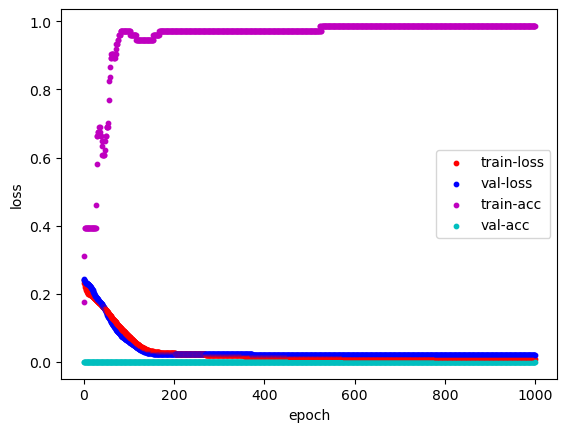

In [19]:
#%% Train the network
plt.figure() # monitor loss curve during training
# for loop over epochs
for epoch in range(num_epoch):
    # classical forward pass -> predict new output from train data
    Y_pred_train_oh = net(X_train)
    # compute loss    
    loss_train = loss_func(Y_pred_train_oh, Y_train_oh)
    
    # Compute gradients
    optimizer.zero_grad()
    # Note: Calling .backward() mutiple times accumulates the gradient (by addition) for each parameter. This is why you should call optimizer.zero_grad() after each .step() call
    # Note that following the first .backward call, a second call is only possible after you have performed another forward pass.
    loss_train.backward()
    # perform a parameter update based on the current gradient (stored in .grad attribute of a parameter)
    optimizer.step()
    
    # TODO**
    # forward pass for validation
    Y_pred_val_oh = net(X_test)
    loss_val = loss_func(Y_pred_val_oh, Y_test_oh)
    # TODO**
    
    # compute actual train accuracy
    y_pred_train = np.argmax(Y_pred_train_oh.cpu().detach().numpy(), axis=1)
    correct_train = np.sum(y_pred_train == Y_train.numpy())
    
    # compute actual val accuracy
    y_pred_val = np.argmax(Y_pred_val_oh.cpu().detach().numpy(), axis=1)
    correct_val = np.sum(y_pred_val == Y_val.numpy())
    
    # plot train and val loss and accuracies
    plt.scatter(epoch, loss_train.data.item(), color='r', s=10, marker='o')
    plt.scatter(epoch, loss_val.data.item(), color='b', s=10, marker='o')
    plt.scatter(epoch, correct_train/Y_train.shape[0], color='m', s=10, marker='o') 
    plt.scatter(epoch, correct_val/Y_val.shape[0], color='c', s=10, marker='o')
    
    # print message with actual losses
    print('Train Epoch: {}/{} ({:.0f}%)\ttrain_Loss: {:.6f}\tval_Loss: {:.6f}'.format(
    epoch+1, num_epoch, epoch/num_epoch*100, loss_train.item(), loss_val.item()))
       

# show training and validation loss    
plt.legend(['train-loss','val-loss','train-acc','val-acc'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(os.path.join(path, 'results/irisflower_loss.png'))
#plt.show()

In [39]:
# %% Test results
# TODO**
# forward pass 
# Y_pred_test_oh is on the GPU, because net and X_test are on the GPU, but we want it on the CPU from now on.
Y_pred_test_oh = net(X_test)
# compute and print losses
loss_test = loss_func(Y_pred_test_oh, Y_test_oh)
# TODO** 
print('Test loss before training was:', loss_test_before.item())
print('Test loss after training is:', loss_test.item())

# compute and print accuracies
y_pred_test = np.argmax(Y_pred_test_oh.cpu().detach().numpy(), axis=1)
correct = np.sum(y_pred_test == Y_test.numpy())
print('Test accuracy before training: ', correct_before/Y_test.shape[0]*100, '%')
print('Test accuracy after training: ', correct/Y_test.shape[0]*100, '%')

Test loss before training was: 0.28438523411750793
Test loss after training is: 0.019889995455741882
Test accuracy before training:  0.0 %
Test accuracy after training:  94.73684210526315 %


In [43]:
# evaluation module
clf = SVC(random_state=0)
clf.fit(X_train, y_pred_train)
SVC(random_state=0)
predictions = clf.predict(X_test)

#%% plot test confusion matrix
cm = confusion_matrix(y_pred_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()
plt.savefig(os.path.join(path, 'results/irisflower_confusion.png'))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.